In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import torch
import torch.nn as nn
from torch_geometric.data import DataLoader
import argparse
import numpy as np
import random
import ogb
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from graph_transformer import GT
from utils import pre_process, pre_process_with_summary, get_n_params, get_optimizer
import datetime
from tqdm import tqdm
from tensorboardX import SummaryWriter
import pytz


In [2]:
parser = argparse.ArgumentParser(description='PyTorch implementation of relative positional encodings and relation-aware self-attention for graph Transformers')
args = parser.parse_args("")

args.dataset = 'ogbg-molbace'
args.n_classes = 1
args.lr = 2e-4
args.n_hid = 512
args.n_heads = 8
args.n_layer = 4
args.dropout = 0.2
args.num_epochs = 10
args.k_hop_neighbors = 3
args.weight_decay = 1e-2
args.bsz      = 128
args.strategies = ['hsd', 'sd', 'ea', 'cn']
args.summary_node = False
args.hier_levels = 3
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", args.device)

device: cuda


In [3]:
print("Loading data...")
print("dataset: {} ".format(args.dataset))
tz = pytz.timezone('US/Pacific')
time_now = datetime.datetime.now(tz).strftime('%m-%d_%H:%M:%S')

if args.summary_node:
    pre_transform = lambda d : pre_process_with_summary(d, args)
    root_path= f'dataset/with_summary_{args.k_hop_neighbors}'
    args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/with_summary_k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')

else:
    pre_transform = lambda d : pre_process(d, args)
    root_path= f'dataset/{args.k_hop_neighbors}'
    args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')
    
    
dataset = PygGraphPropPredDataset(name=args.dataset, pre_transform=pre_transform, root = root_path)
evaluator = Evaluator(name=args.dataset)
split_idx = dataset.get_idx_split()
edge_dim_dict = {'ea': dataset.data.edge_attr.max(dim=0)[0].int().view(-1) + 1, \
                 'sd': (dataset.data.sd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
                 'cn': (dataset.data.cn_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
                 'hsd': (dataset.data.hsd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist()}
model = GT(args.n_hid, args.n_classes, args.n_heads, args.n_layer, edge_dim_dict, args.dropout, args.summary_node).to(args.device)

Loading data...
dataset: ogbg-molbace 


In [4]:
# Regular loader
# train_loader = DataLoader(dataset[split_idx["train"]], batch_size=args.bsz, shuffle=True)
# valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.bsz, shuffle=False)
# test_loader  = DataLoader(dataset[split_idx["test"]],  batch_size=args.bsz, shuffle=False)

In [5]:
# Loader with weighted sampler, for unbalanced data

from torch.utils.data import WeightedRandomSampler
weight = [1.0, np.sqrt((dataset.data.y == 0).sum().item() / (dataset.data.y == 1).sum().item())]
samples_weight = np.array([weight[yi] for yi in dataset.data.y.view(-1)[split_idx["train"]]])

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(dataset[split_idx["train"]], batch_size=args.bsz, sampler = sampler)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.bsz, shuffle = False)
test_loader  = DataLoader(dataset[split_idx["test"]],  batch_size=args.bsz, shuffle = False)

In [6]:
print('Model #Params: %d' % get_n_params(model))

criterion = torch.nn.BCEWithLogitsLoss(reduction = "mean")

optimizer = get_optimizer(model, weight_decay = args.weight_decay)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, pct_start = 0.05,\
        steps_per_epoch=len(train_loader), epochs = args.num_epochs, anneal_strategy = 'linear')

Model #Params: 8571905


In [7]:
stats = []
for epoch in range(args.num_epochs):
    model.train()
    train_loss = []
    for num_iters, data in enumerate(tqdm(train_loader)):
        data.to(args.device)
        strats = {'ea': data.edge_attr, 'cn': data.cn_edge_attr, 'sd': data.sd_edge_attr, 'hsd': data.hsd_edge_attr.long()}
        out = model(data.x, data.batch, data.edge_index, strats)
        loss = criterion(out, data.y.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
        train_loss += [loss.item()]
        
    args.writer.add_scalar("LR/epoch", optimizer.param_groups[0]['lr'], epoch + 1)
    args.writer.add_scalar("Loss/train", np.average(train_loss), epoch + 1)

    model.eval()
    with torch.no_grad():
        valid_loss = []
        y_true = []
        y_scores = []
        for num_iters, data in enumerate(tqdm(valid_loader)):
            data.to(args.device)
            strats = {'ea': data.edge_attr, 'cn': data.cn_edge_attr, 'sd': data.sd_edge_attr, 'hsd': data.hsd_edge_attr.long()}
            out = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            valid_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        valid_rocauc = evaluator.eval(input_dict)['rocauc']
        args.writer.add_scalar("Loss/valid", np.average(valid_loss), epoch + 1)
        args.writer.add_scalar("ROC/valid", valid_rocauc, epoch + 1)
        
        test_loss = []
        y_true = []
        y_scores = []
        for data in test_loader:
            data.to(args.device)
            strats = {'ea': data.edge_attr, 'cn': data.cn_edge_attr, 'sd': data.sd_edge_attr, 'hsd': data.hsd_edge_attr.long()}
            out = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            test_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        test_rocauc = evaluator.eval(input_dict)['rocauc']
        args.writer.add_scalar("Loss/test", np.average(test_loss), epoch + 1)
        args.writer.add_scalar("ROC/test", test_rocauc, epoch + 1)
    
    print('Epoch %d: LR: %.5f, Train loss: %.3f Valid loss: %.3f  Valid ROC-AUC: %.3f Test loss: %.3f  Test ROC-AUC: %.3f' \
          % (epoch + 1, optimizer.param_groups[0]['lr'], np.average(train_loss), np.average(valid_loss), \
            valid_rocauc, np.average(test_loss), test_rocauc))
    stats += [[epoch, np.average(train_loss), np.average(valid_loss), valid_rocauc, np.average(test_loss), test_rocauc]]

args.writer.close()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: LR: 0.00019, Train loss: 0.711 Valid loss: 0.854  Valid ROC-AUC: 0.632 Test loss: 0.993  Test ROC-AUC: 0.672


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2: LR: 0.00017, Train loss: 0.687 Valid loss: 0.671  Valid ROC-AUC: 0.658 Test loss: 0.663  Test ROC-AUC: 0.669


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3: LR: 0.00015, Train loss: 0.622 Valid loss: 1.011  Valid ROC-AUC: 0.630 Test loss: 1.278  Test ROC-AUC: 0.671


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4: LR: 0.00012, Train loss: 0.640 Valid loss: 0.988  Valid ROC-AUC: 0.603 Test loss: 1.290  Test ROC-AUC: 0.666


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5: LR: 0.00010, Train loss: 0.592 Valid loss: 0.720  Valid ROC-AUC: 0.597 Test loss: 0.869  Test ROC-AUC: 0.660


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6: LR: 0.00008, Train loss: 0.566 Valid loss: 0.760  Valid ROC-AUC: 0.649 Test loss: 0.958  Test ROC-AUC: 0.685


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7: LR: 0.00006, Train loss: 0.573 Valid loss: 0.748  Valid ROC-AUC: 0.664 Test loss: 0.954  Test ROC-AUC: 0.688


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8: LR: 0.00004, Train loss: 0.541 Valid loss: 0.727  Valid ROC-AUC: 0.635 Test loss: 0.932  Test ROC-AUC: 0.677


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9: LR: 0.00002, Train loss: 0.556 Valid loss: 0.852  Valid ROC-AUC: 0.648 Test loss: 1.199  Test ROC-AUC: 0.692


100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


Epoch 10: LR: -0.00000, Train loss: 0.529 Valid loss: 0.854  Valid ROC-AUC: 0.656 Test loss: 1.203  Test ROC-AUC: 0.702


[6.         0.57300374 0.74760404 0.66410256 0.95413649 0.68788037]


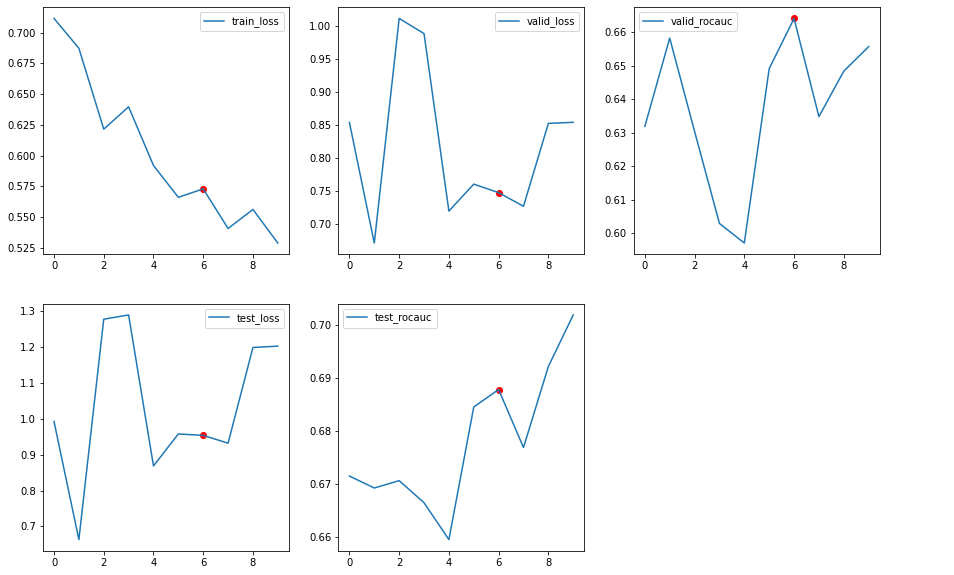

In [8]:
import matplotlib.pyplot as plt
labels = ['epoch', 'train_loss', 'valid_loss', 'valid_rocauc', 'test_loss', 'test_rocauc']
fig = plt.figure(figsize=(15, 10))
stats_np = np.array(stats)
best_valid = stats_np[stats_np[:, 3].argmax()]
print(best_valid)
for i in range(1, stats_np.shape[-1]):
    ax = fig.add_subplot(2, 3, i)
    ax.plot(stats_np[:, i], label=labels[i])
    ax.scatter(x=best_valid[0], y=best_valid[i], color='red')
    ax.annotate(text=best_valid[i].round(3), xy=(best_valid[0]+5, best_valid[i]), color='red')
    ax.legend()
